In [1]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
dataset=pd.read_csv("dataset.csv",sep=";")
dataset.drop(["node"],inplace=True,axis=1)
dataset["date"]=pd.to_datetime(dataset["date"],format="%Y-%m-%d %H:%M:%S")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242968 entries, 0 to 2242967
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   consumption  float64       
 1   substation   object        
 2   date         datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 51.3+ MB


In [3]:
train=dataset.query("date.dt.year>2017 and date.dt.year <2022")
train=train.set_index("date")

In [4]:
test=dataset.query("date.dt.year==2022")
test=test.set_index("date")

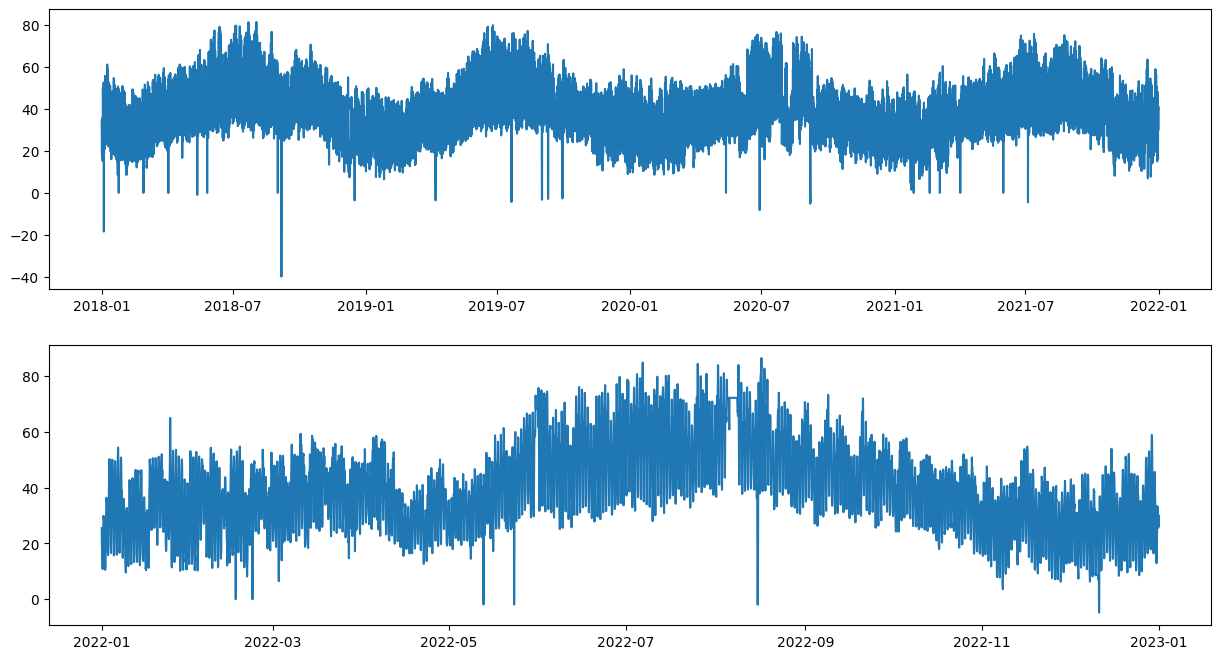

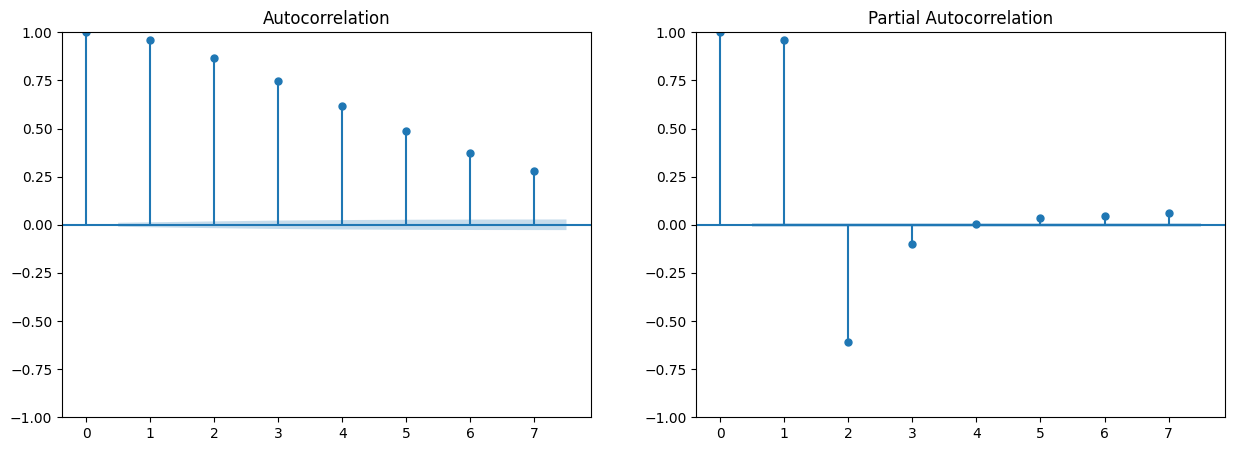

In [5]:
subestacion="AJAHUEL"
filtro="substation=='{0}'".format(subestacion)
ds_train=train.query(filtro)["consumption"].groupby("date").aggregate(consumption="mean")
ym=ds_train["consumption"].to_numpy()
xm=ds_train.index.to_numpy()
filtro="substation=='{0}'".format(subestacion)
ds_test=test.query(filtro)["consumption"].groupby("date").aggregate(consumption="mean")
ytm=ds_test["consumption"].to_numpy()
xtm=ds_test.index.to_numpy()
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm,ym);
axes[1].plot(xtm,ytm);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ym,lags=7,ax=axes[0]);
plot_pacf(ym,lags=7,method="ywm",ax=axes[1]);


Revisión de Datos Faltantes

In [6]:
deltas = 365*24*4
#agregamos un día al rango por el año bisiesto 2020
deltas+=24
start = datetime.datetime.strptime("2018-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
train_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]
deltas = 365*24
start = datetime.datetime.strptime("2022-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
test_full = [start + datetime.timedelta(hours=x) for x in range(deltas)]
missing_train=[]
for fecha in train_full:
    if not (fecha in ds_train.index):
        missing_train.append(fecha)
missing_test=[]
for fecha in test_full:
    if not (fecha in ds_test.index): 
        missing_test.append(fecha)
print(len(train_full),len(ds_train),len(missing_train))
print(len(test_full),len(ds_test),len(missing_test))
for missing in missing_test:
    print(missing.strftime('%Y-%m-%d %H:%M:%S')) 

35064 34913 151
8760 8759 1
2022-09-11 00:00:00


Imputación de Datos Faltantes usando moving average t-1 y t+1

In [7]:
for missing in missing_test:
    delta=1
    hora_previa=missing-datetime.timedelta(hours=delta)
    while(not (hora_previa in ds_test.index)):
        delta=delta+1
        hora_previa=missing-datetime.timedelta(hours=delta)
    delta=1
    hora_siguiente=missing+datetime.timedelta(hours=delta)
    while(not (hora_siguiente in ds_test.index)):
        delta=delta+1
        hora_siguiente=missing+datetime.timedelta(hours=delta)

    consumo_previo=ds_test.loc[hora_previa]["consumption"]
    consumo_siguiente=ds_test.loc[hora_siguiente]["consumption"]
    consumo_faltante=(consumo_previo+consumo_siguiente)/2
    print(hora_previa,missing,hora_siguiente)
    print(consumo_previo,consumo_faltante,consumo_siguiente)
    ds_test.loc[missing]=[consumo_faltante]
rango=pd.date_range(start=missing-datetime.timedelta(hours=3),end=missing+datetime.timedelta(hours=3),freq="1h")
ds_test.loc[rango]

2022-09-10 23:00:00 2022-09-11 00:00:00 2022-09-11 01:00:00
56.035658999999995 53.612227624999996 51.188796249999996


,consumption
2022-09-10 21:00:00,59.586017
2022-09-10 22:00:00,58.615204
2022-09-10 23:00:00,56.035659
2022-09-11 00:00:00,53.612228
2022-09-11 01:00:00,51.188796
2022-09-11 02:00:00,44.201565
2022-09-11 03:00:00,38.709258


In [8]:
for missing in missing_train:
    delta=1
    hora_previa=missing-datetime.timedelta(hours=delta)
    while(not (hora_previa in ds_train.index)):
        delta=delta+1
        hora_previa=missing-datetime.timedelta(hours=delta)
    delta=1
    hora_siguiente=missing+datetime.timedelta(hours=delta)
    while(not (hora_siguiente in ds_train.index)):
        delta=delta+1
        hora_siguiente=missing+datetime.timedelta(hours=delta)
        
    consumo_previo=ds_train.loc[hora_previa]["consumption"]
    consumo_siguiente=ds_train.loc[hora_siguiente]["consumption"]
    consumo_faltante=(consumo_previo+consumo_siguiente)/2
    ds_train.loc[missing]=[consumo_faltante]
len(ds_train)

35064

In [9]:
ds_train.sort_index(inplace=True)
ds_test.sort_index(inplace=True)
ds_train.to_csv("train_hora.csv")
ds_test.to_csv("test_hora.csv")

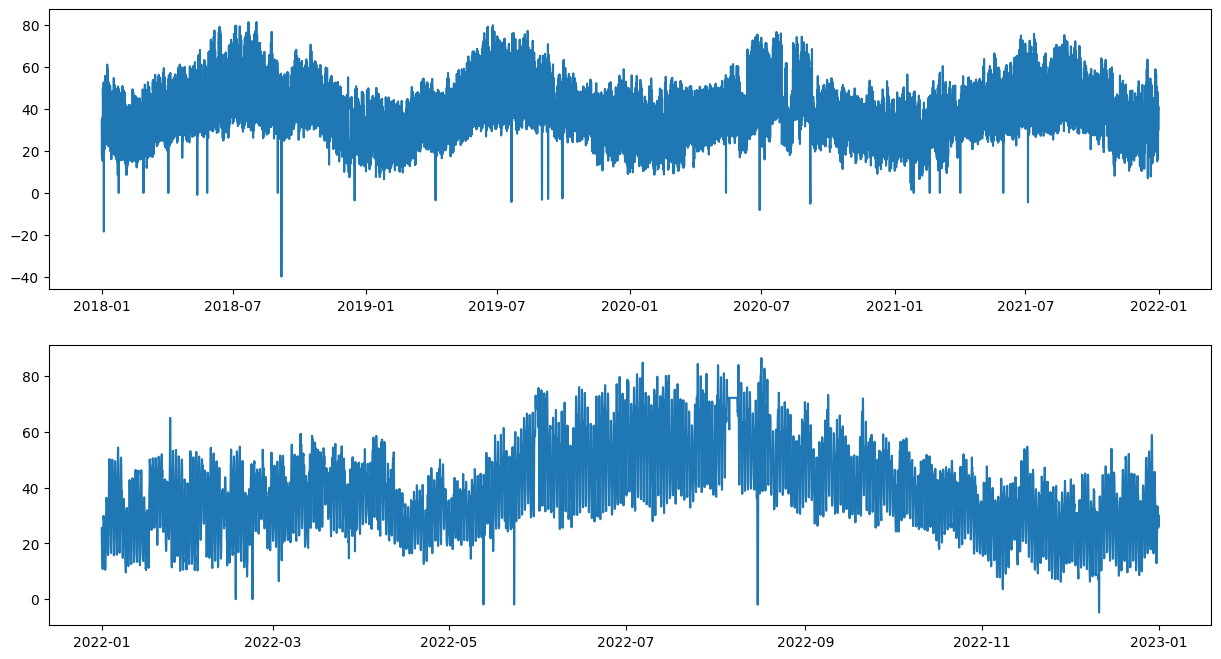

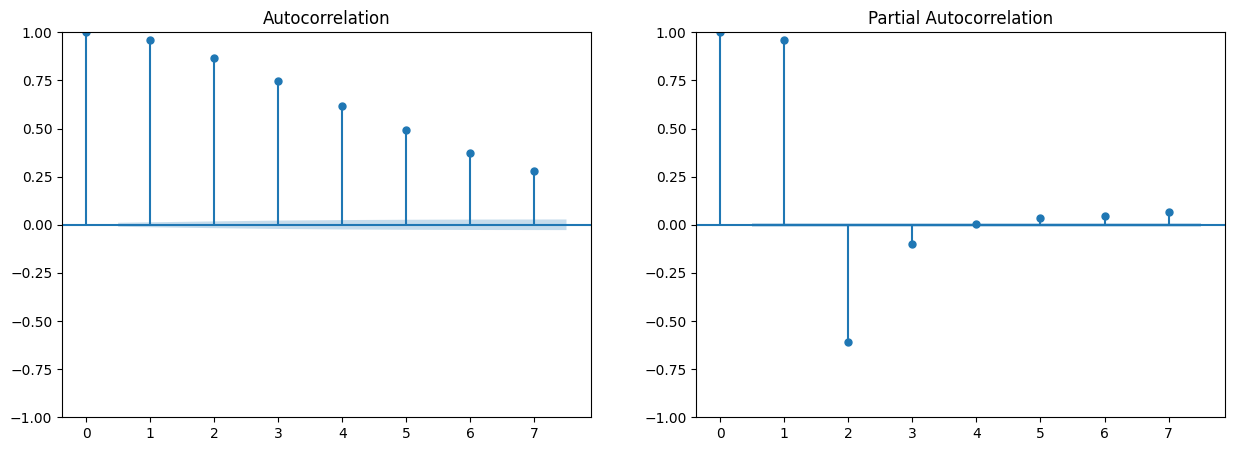

In [14]:
ym=ds_train["consumption"].to_numpy()
xm=ds_train.index.to_numpy()
ytm=ds_test["consumption"].to_numpy()
xtm=ds_test.index.to_numpy()
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm,ym);
axes[1].plot(xtm,ytm);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ym,lags=7,ax=axes[0]);
plot_pacf(ym,lags=7,method="ywm",ax=axes[1]);

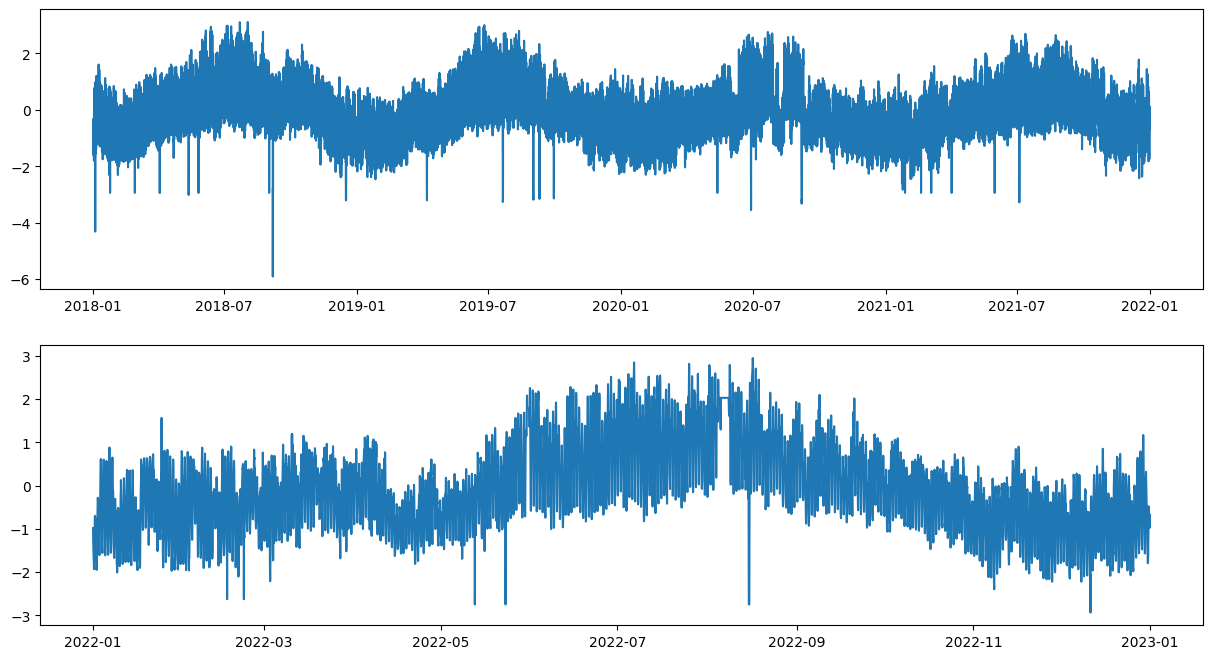

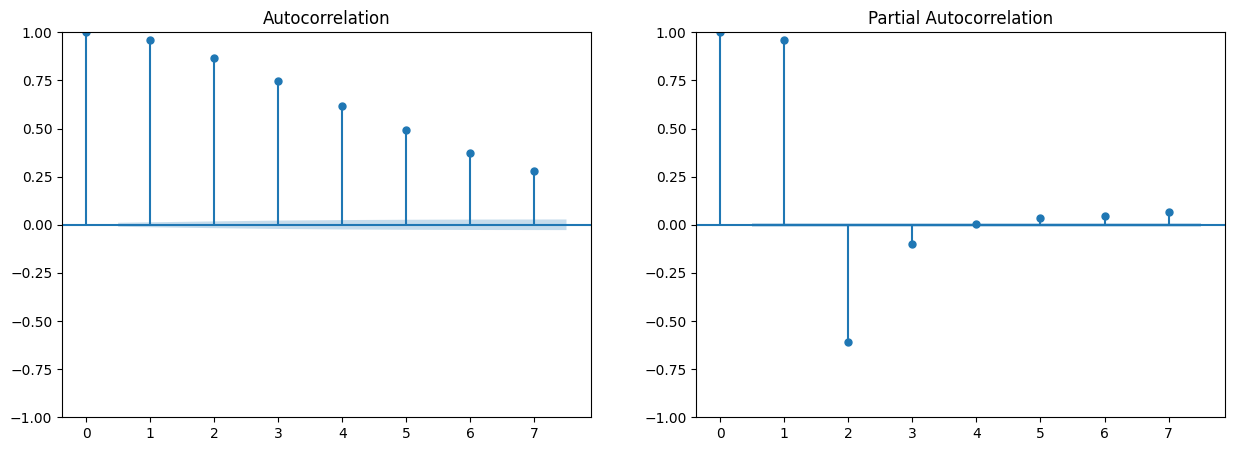

In [15]:
scaler = StandardScaler()
ym=ym.reshape(-1,1)
scaler.fit(ym)
ym_z=scaler.transform(ym)
ytm=ytm.reshape(-1,1)
scaler.fit(ytm)
ytm_z=scaler.transform(ytm)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm,ym_z);
axes[1].plot(xtm,ytm_z);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(ym_z,lags=7,ax=axes[0]);
plot_pacf(ym_z,lags=7,method="ywm",ax=axes[1]);

In [16]:
result = adfuller(ym)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.436962
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [17]:
modelo_ajahuel_d=ARIMA(ym,order=(2,0,2))
m_ad1=modelo_ajahuel_d.fit()
print("MSE",m_ad1.mse)
print("AIC",m_ad1.aic)
ymp=m_ad1.predict()
ytmp=m_ad1.forecast(7*24)

MSE 9.157646477194756
AIC 177171.94706642439


39.415700362379795 1.8069110803878188 0.0458424197407493


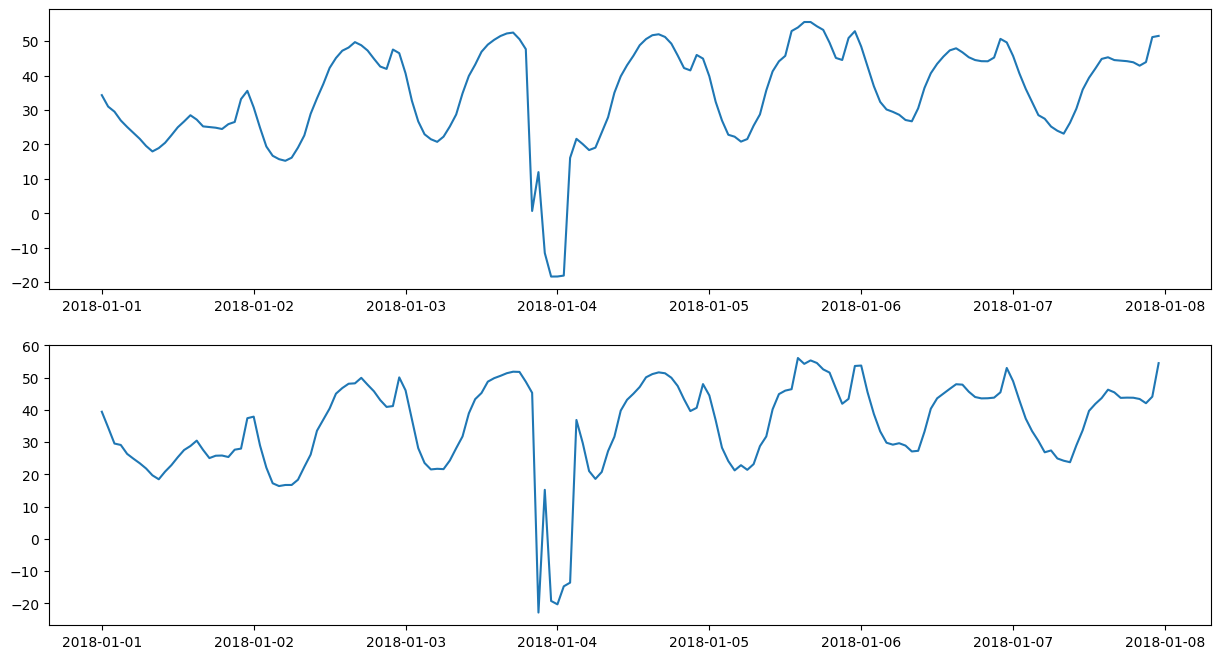

In [18]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xm[:7*24],ym[:7*24]);
axes[1].plot(xm[:7*24],ymp[:7*24]);
media=np.mean(ym)
error=mean_absolute_error(ym,ymp)
print(media,error,error/media)

31.583435941964282 11.524809429282811 0.3649004323171193


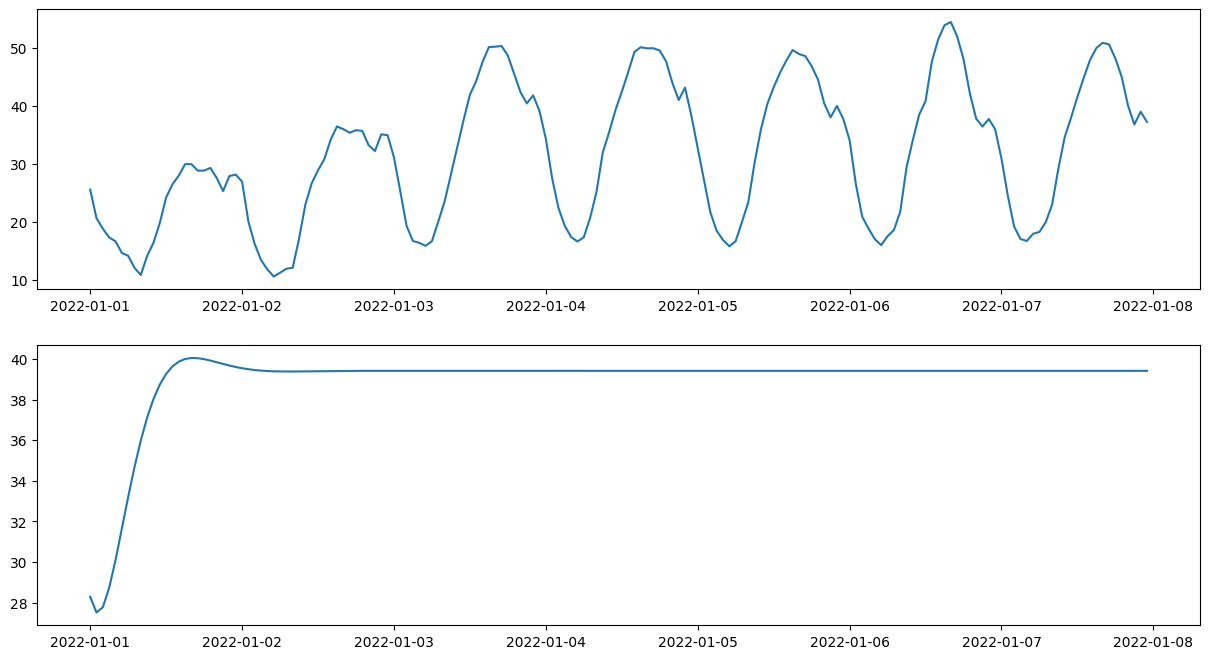

In [19]:
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(xtm[:7*24],ytm[:7*24]);
axes[1].plot(xtm[:7*24],ytmp);
media=np.mean(ytm[:7*24])
error=mean_absolute_error(ytm[:7*24],ytmp)
print(media,error,error/media)

In [20]:
yw=[]
yt=[]
window=2
for i in range(0,len(ym)):
    if i+window < len(ym):
        row=[]
        for j in range(window):
            row.append(ym[i+j])
        yw.append(row)
        yt.append(ym[i+window])
    else:
        break
print(len(yw))
yw=np.asarray(yw)
yt=np.asarray(yt)

35062


In [21]:
yw_test=[]
yt_test=[]
window=2
for i in range(0,len(ytm)):
    if i+window < len(ytm):
        row=[]
        for j in range(window):
            row.append(ytm[i+j])
        yw_test.append(row)
        yt_test.append(ytm[i+window])
    else:
        break
print(len(yw_test))
yw_test=np.asarray(yw_test)
yt_test=np.asarray(yt_test)

8758


In [40]:
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from keras.layers import SimpleRNN, LSTM, Input, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random as rd

In [23]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
model = Sequential()
model.add(Input(name="serie",shape=(2,1)))
model.add(SimpleRNN(256))
model.add(Dense(128))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 99,073 (387.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
tag="rnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

model.compile(optimizer="Adam", loss='huber', metrics=['mse','mae'])
rnn = model.fit(yw, yt, validation_data=(yw_test,yt_test),
                batch_size=256, epochs=64,shuffle=True,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.9096 - mae: 10.3829 - mse: 289.0686 - val_loss: 1.6304 - val_mae: 2.0725 - val_mse: 10.5020
Epoch 2/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5692 - mae: 2.0015 - mse: 9.5900 - val_loss: 1.5046 - val_mae: 1.9364 - val_mse: 9.6328
Epoch 3/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4352 - mae: 1.8612 - mse: 8.8188 - val_loss: 1.4870 - val_mae: 1.9184 - val_mse: 9.4709
Epoch 4/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4093 - mae: 1.8344 - mse: 8.6606 - val_loss: 1.4816 - val_mae: 1.9130 - val_mse: 9.3979
Epoch 5/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3920 - mae: 1.8162 - mse: 8.5561 - val_loss: 1.4677 - val_mae: 1.9003 - val_mse: 9.3127
Epoch 6/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3858 - mae: 1.8101 - mse: 8.5126 - val_loss: 1.4570 - val_mae: 1.8897 - val_mse: 9.2594
Epoch 7/64
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3800 - mae: 1.8040 - mse: 8.4721 -

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
39.41608503249202 1.6067663128095335 0.04076422890515437


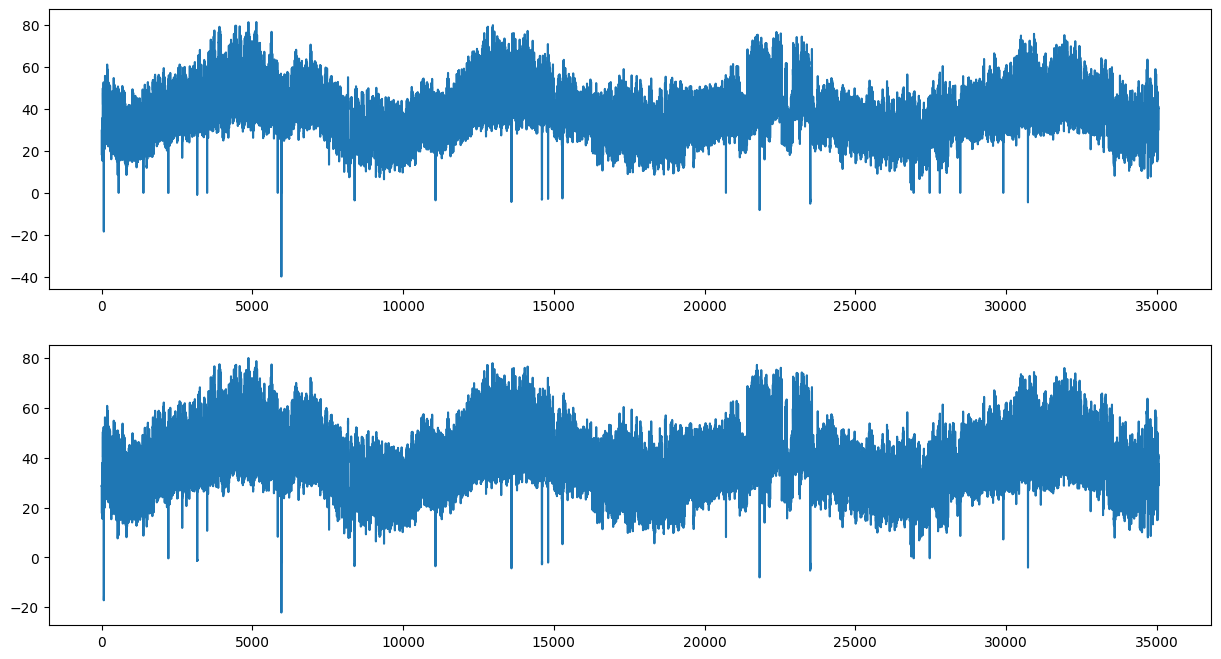

In [25]:
yp=model.predict(yw)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(yt);
axes[1].plot(yp);
media=np.mean(yt)
error=mean_absolute_error(yt,yp)
print(media,error,error/media)

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
40.74233941891699 1.7723190748201891 0.04350067031244866


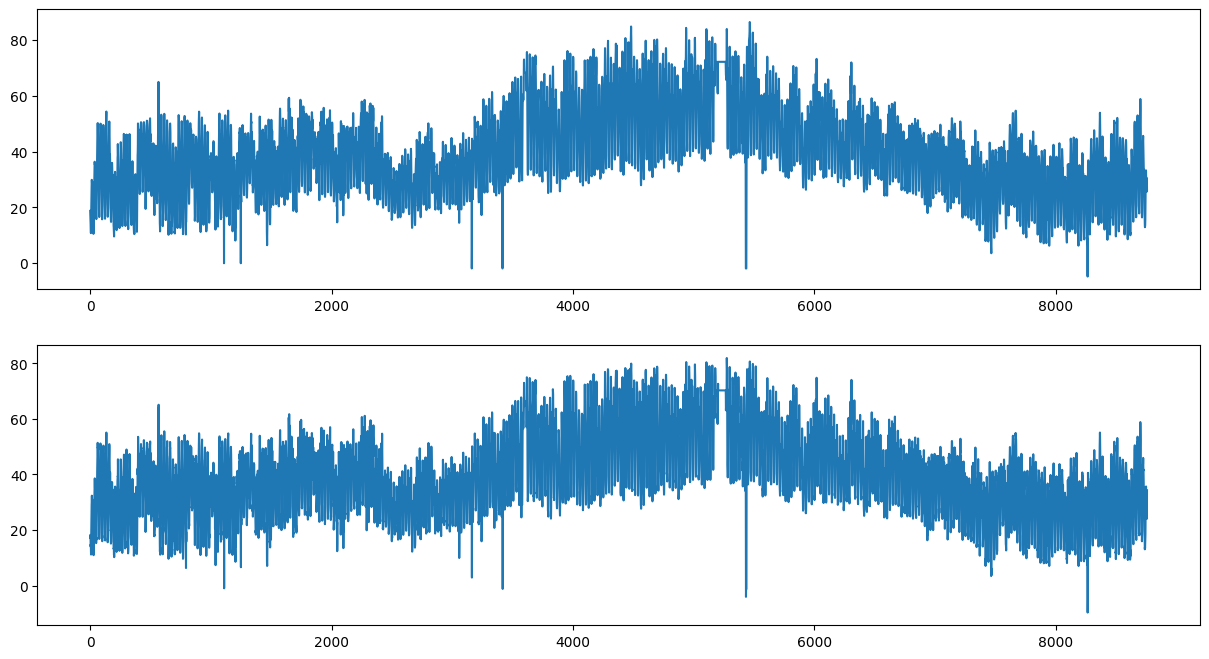

In [26]:
yp_test=model.predict(yw_test)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(yt_test);
axes[1].plot(yp_test);
media=np.mean(yt_test)
error=mean_absolute_error(yt_test,yp_test)
print(media,error,error/media)

31.674065425595234 11.627892462852842 0.3671108304732033


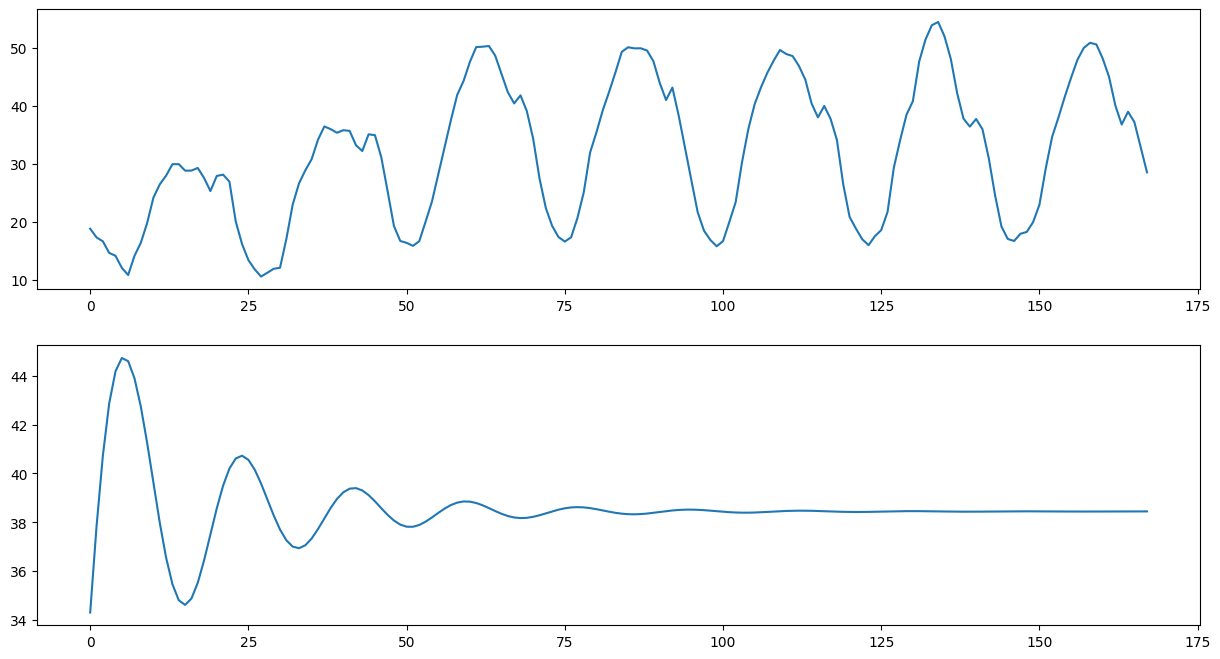

In [27]:
ultimo=yw_test[-1].copy().reshape(1,2,1)
forecasts=[]
horizonte=7*24
for i in range(horizonte):
    forecast=model.predict(ultimo,verbose=0);
    valor=forecast.reshape(1)[0]
    forecasts.append(valor)
    lista=ultimo.reshape(1,2)[0].tolist()
    lista.pop(0)
    lista.append(valor)
    siguiente=np.asarray(lista).reshape(1,2,1)
    ultimo=siguiente
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(yt_test[:horizonte]);
axes[1].plot(forecasts);
media=np.mean(yt_test[:horizonte])
error=mean_absolute_error(yt_test[:horizonte],forecasts)
print(media,error,error/media)

In [28]:
yw=[]
yt=[]
window=216
for i in range(0,len(ym)):
    if i+window < len(ym):
        row=[]
        for j in range(48):
            row.append(ym[i+j])
        yw.append(row)
        row=[]
        for j in range(168):
            row.append(ym[i+48+j])
        yt.append(row)
    else:
        break
print(len(yw))
yw=np.asarray(yw)
yt=np.asarray(yt)

34848


In [29]:
yw_test=[]
yt_test=[]
window=216
for i in range(0,len(ytm)):
    if i+window < len(ytm):
        row=[]
        for j in range(48):
            row.append(ytm[i+j])
        yw_test.append(row)
        row=[]
        for j in range(168):
            row.append(ytm[i+48+j])
        yt_test.append(row)
    else:
        break
print(len(yw_test))
yw_test=np.asarray(yw_test)
yt_test=np.asarray(yt_test)

8544


In [44]:
seed=12122008
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
model = Sequential()
model.add(Input(name="serie",shape=(48,1)))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dense(168, activation='linear'))
tag="mrnn"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-4)

model.compile(optimizer="Adam", loss='huber', metrics=['mse','mae'])
rnn = model.fit(yw, yt, validation_data=(yw_test,yt_test),
                batch_size=256, epochs=32,shuffle=True,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag))

Epoch 1/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - loss: 20.4031 - mae: 20.8979 - mse: 691.3552 - val_loss: 11.5346 - val_mae: 12.0312 - val_mse: 230.1355
Epoch 2/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 28s 206ms/step - loss: 9.7155 - mae: 10.2062 - mse: 157.4040 - val_loss: 9.6266 - val_mae: 10.1107 - val_mse: 152.1669
Epoch 3/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 28s 207ms/step - loss: 8.7505 - mae: 9.2401 - mse: 128.9368 - val_loss: 8.3453 - val_mae: 8.8413 - val_mse: 123.0838
Epoch 4/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 30s 219ms/step - loss: 7.5746 - mae: 8.0615 - mse: 104.7285 - val_loss: 6.3063 - val_mae: 6.8172 - val_mse: 78.5086
Epoch 5/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 30s 216ms/step - loss: 5.9124 - mae: 6.3942 - mse: 72.7742 - val_loss: 6.1323 - val_mae: 6.6384 - val_mse: 76.9055
Epoch 6/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - loss: 5.6423 - mae: 6.1232 - mse: 67.6768 - val_loss: 5.7879 - val_mae: 6.2902 - val_mse: 69.5371
Epoch 7/32
137/137 ━━━━━━━━━━━━━━━━━━━━ 29s 211ms/step - 

In [45]:
ultimo=yw_test[-1].reshape(1,48,1)
ultimo.shape

(1, 48, 1)

31.84599220386905 6.411338647506715 0.2013232499230401 0.21035629168943099


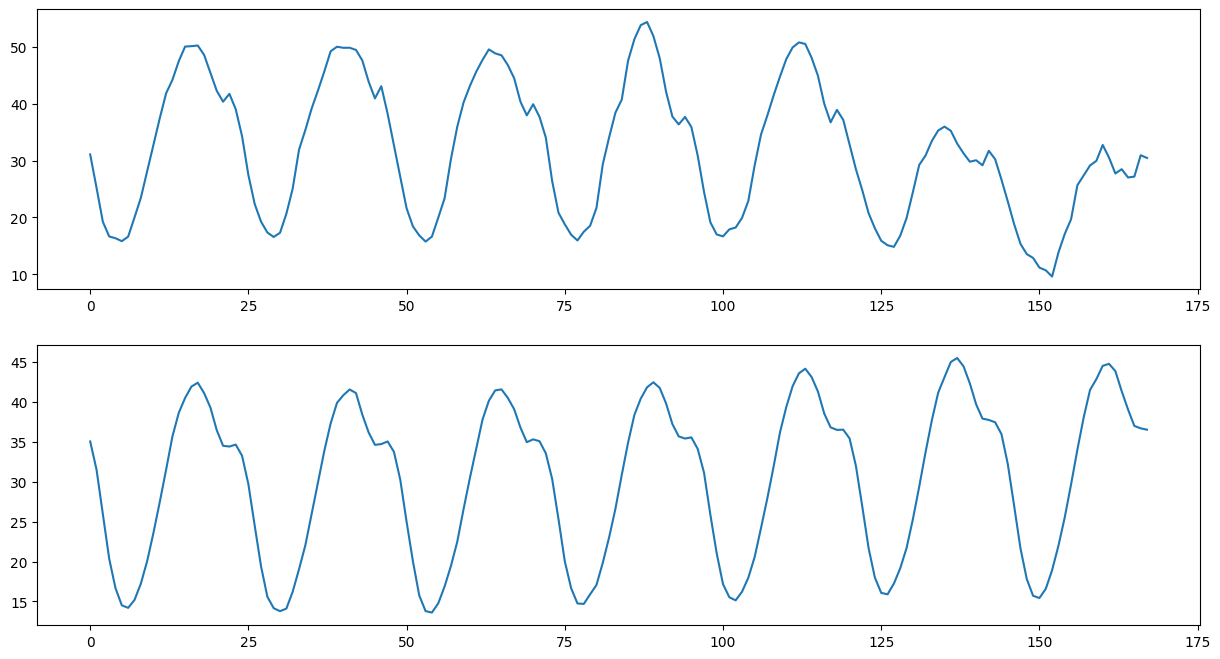

In [48]:
from sklearn.metrics import mean_absolute_percentage_error
forecast=model.predict(ultimo,verbose=0)
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
real=yt_test[0].tolist()
pred=forecast[0].tolist()
axes[0].plot(real);
axes[1].plot(pred);
media=np.mean(real)
error=mean_absolute_error(real,pred)
error2=mean_absolute_percentage_error(real,pred)
print(media,error,error/media,error2)